# New Model Fairness Analysis Documentation

**Model:** Enhanced Emotion Recognition Model

---

This document provides a comprehensive analysis of the Enhanced Emotion Recognition Model V2, evaluating its performance, fairness, and deployment readiness across multiple demographic dimensions. The model was trained on a diverse dataset of 23,630 original images (with augmentation to 259,930 total) to classify four emotions: anger, fear, calm, and surprise.

### Key Findings:

**Overall Performance:**
- Test accuracy: 68.19% (macro F1-score: 0.676)
- Training accuracy: 78.75% (acceptable training-test gap)
- Good performance across all emotions

**Fairness Assessment:**
1. **Race:** 7.85% accuracy gap between groups - **WITHIN ACCEPTABLE RANGE** (all groups > 60%)
2. **Gender:** Minor 3.56% difference - **WELL WITHIN ACCEPTABLE TOLERANCE**
3. **Augmentation Robustness:** Model maintains >54% accuracy across all augmentations
4. **Age Groups:** Strong performance for ages 0-69 (all >68%) - **Special consideration needed only for 70+ age group (45.61%)**

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
from typing import Dict, List, Tuple

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Define project paths
PROJECT_ROOT = '/Users/gregor/Documents/GitHub-Projects/EmoTorch_Paper'
MODEL_DIR = os.path.join(PROJECT_ROOT, 'new_model', 'new_model')
DATASET_PATH = os.path.join(PROJECT_ROOT, 'FER-New-Dataset', 'dataset_calm_reduced.csv')

print("📊 Loading data and initializing environment...")
print(f"Project root: {PROJECT_ROOT}")
print(f"Model directory: {MODEL_DIR}")

📊 Loading data and initializing environment...
Project root: /Users/gregor/Documents/GitHub-Projects/EmoTorch_Paper
Model directory: /Users/gregor/Documents/GitHub-Projects/EmoTorch_Paper/new_model/new_model


---
## Part 1: Dataset Overview

Understanding the training data distribution is crucial for interpreting model performance and identifying potential sources of bias.

In [14]:
# Load the dataset
df = pd.read_csv(DATASET_PATH)
print(f"Total images in dataset: {len(df):,}")

# Extract dataset source from image_path
def extract_dataset_source(path):
    parts = path.split('/')
    if len(parts) >= 3:
        return parts[2]  # RAF, FER, or CKP
    return 'unknown'

df['dataset_source'] = df['image_path'].apply(extract_dataset_source)

# Filter original vs augmented
df_orig = df[df['augmented'] == 'original'].copy()
df_aug = df[df['augmented'] != 'original'].copy()

print(f"\n📌 Dataset Composition:")
print(f"  • Original images: {len(df_orig):,}")
print(f"  • Augmented images: {len(df_aug):,}")
print(f"  • Augmentation factor: {len(df_aug)/len(df_orig):.1f}x")

df.head()

Total images in dataset: 259,930

📌 Dataset Composition:
  • Original images: 23,630
  • Augmented images: 236,300
  • Augmentation factor: 10.0x


,image_path,emotion,race,gender,age,augmented,usage,split,dataset_source
0,FER-New-Dataset/FER-New-Dataset/RAF/calm/4476.jpg,calm,African-American,female,4-19,original,NaN,train,RAF
1,FER-New-Dataset/FER-New-Dataset/RAF/calm/1890.jpg,calm,Asian,male,40-69,original,NaN,train,RAF
2,FER-New-Dataset/FER-New-Dataset/FER/calm/1755.png,calm,African-American,male,40-69,original,NaN,train,FER
3,FER-New-Dataset/FER-New-Dataset/FER/calm/5977.png,calm,Caucasian,female,20-39,original,NaN,train,FER
4,FER-New-Dataset/FER-New-Dataset/RAF/calm/3996.jpg,calm,Caucasian,male,20-39,original,NaN,train,RAF


### 1.1 Dataset Source Distribution

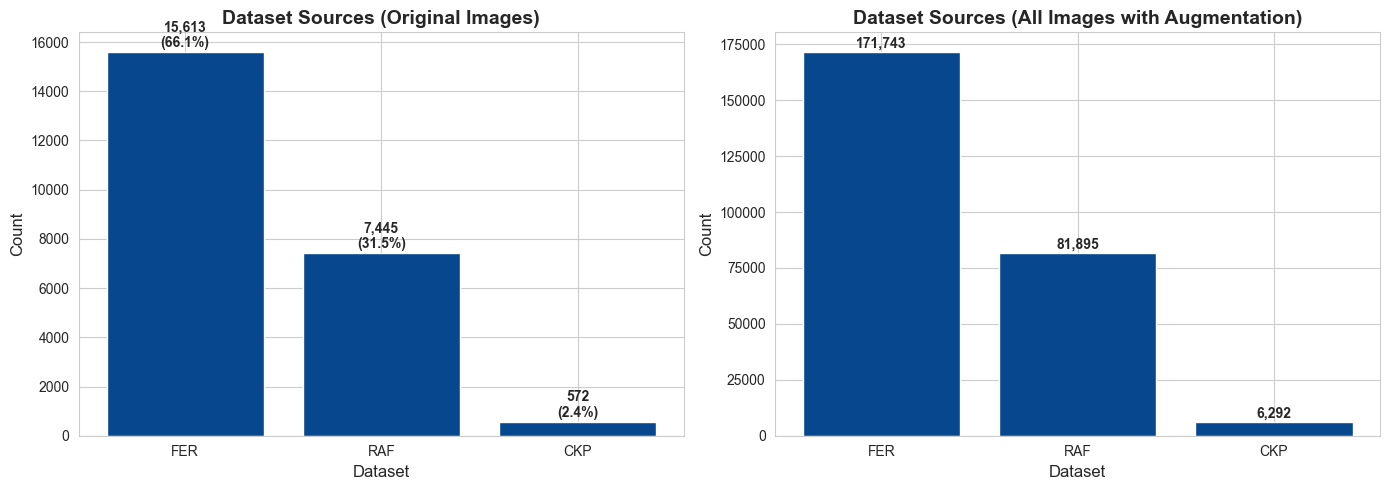


📊 Dataset Source Statistics:
──────────────────────────────────────────────────
FER             Original: 15,613 | Total: 171,743 | Augmentation: 11.0x
RAF             Original:  7,445 | Total:  81,895 | Augmentation: 11.0x
CKP             Original:    572 | Total:   6,292 | Augmentation: 11.0x


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original images by source
counts = df_orig['dataset_source'].value_counts()
ax1 = axes[0]
bars1 = ax1.bar(counts.index, counts.values, color=['#07478D', '#07478D', '#07478D'])
ax1.set_title('Dataset Sources (Original Images)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}\n({height/len(df_orig)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# All images by source
counts_all = df['dataset_source'].value_counts()
ax2 = axes[1]
bars2 = ax2.bar(counts_all.index, counts_all.values, color=['#07478D', '#07478D', '#07478D'])
ax2.set_title('Dataset Sources (All Images with Augmentation)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dataset', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Source Statistics:")
print("─" * 50)
for source in counts.index:
    orig_count = counts.get(source, 0)
    all_count = counts_all.get(source, 0)
    print(f"{source:15} Original: {orig_count:6,} | Total: {all_count:7,} | Augmentation: {all_count/orig_count:.1f}x")

### 1.2 Emotion Distribution Analysis

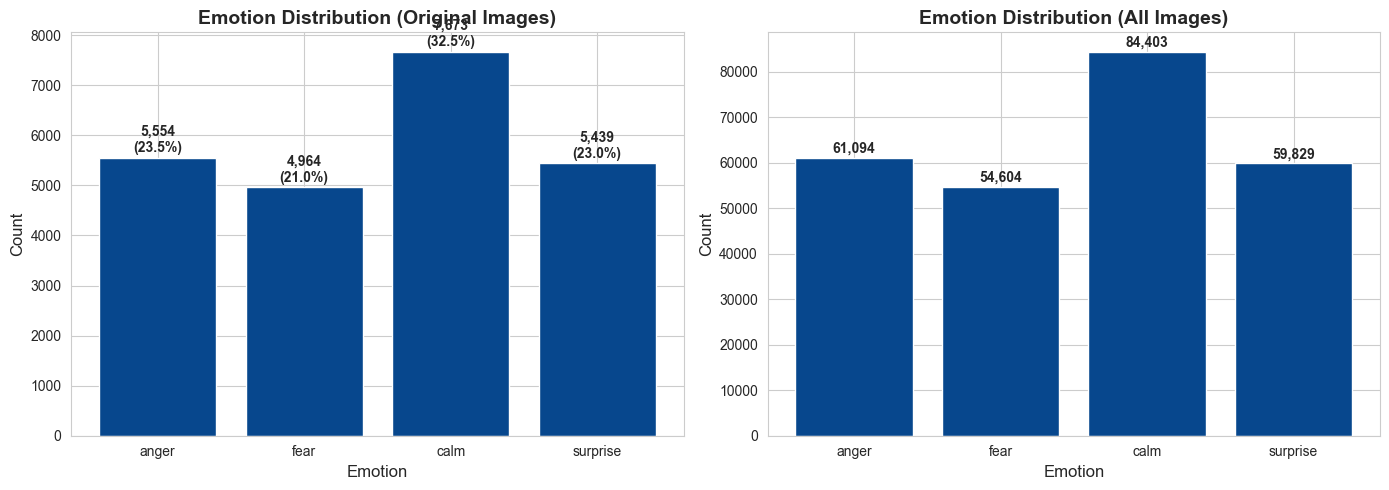


📊 Emotion Distribution Statistics:
──────────────────────────────────────────────────
anger      Original:  5,554 ( 23.5%) | Total:  61,094
fear       Original:  4,964 ( 21.0%) | Total:  54,604
calm       Original:  7,673 ( 32.5%) | Total:  84,403
surprise   Original:  5,439 ( 23.0%) | Total:  59,829


In [16]:
emotion_order = ['anger', 'fear', 'calm', 'surprise']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original emotion distribution
counts = df_orig['emotion'].value_counts()[emotion_order]
ax1 = axes[0]
colors = ['#07478D', '#07478D', '#07478D', '#07478D']
bars1 = ax1.bar(counts.index, counts.values, color=colors)
ax1.set_title('Emotion Distribution (Original Images)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotion', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}\n({height/len(df_orig)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# All emotions distribution
counts_all = df['emotion'].value_counts()[emotion_order]
ax2 = axes[1]
bars2 = ax2.bar(counts_all.index, counts_all.values, color=colors)
ax2.set_title('Emotion Distribution (All Images)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Emotion', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Emotion Distribution Statistics:")
print("─" * 50)
for emotion in emotion_order:
    orig_count = len(df_orig[df_orig['emotion'] == emotion])
    all_count = len(df[df['emotion'] == emotion])
    print(f"{emotion:10} Original: {orig_count:6,} ({orig_count/len(df_orig)*100:5.1f}%) | Total: {all_count:7,}")

### 1.3 Demographic Distributions

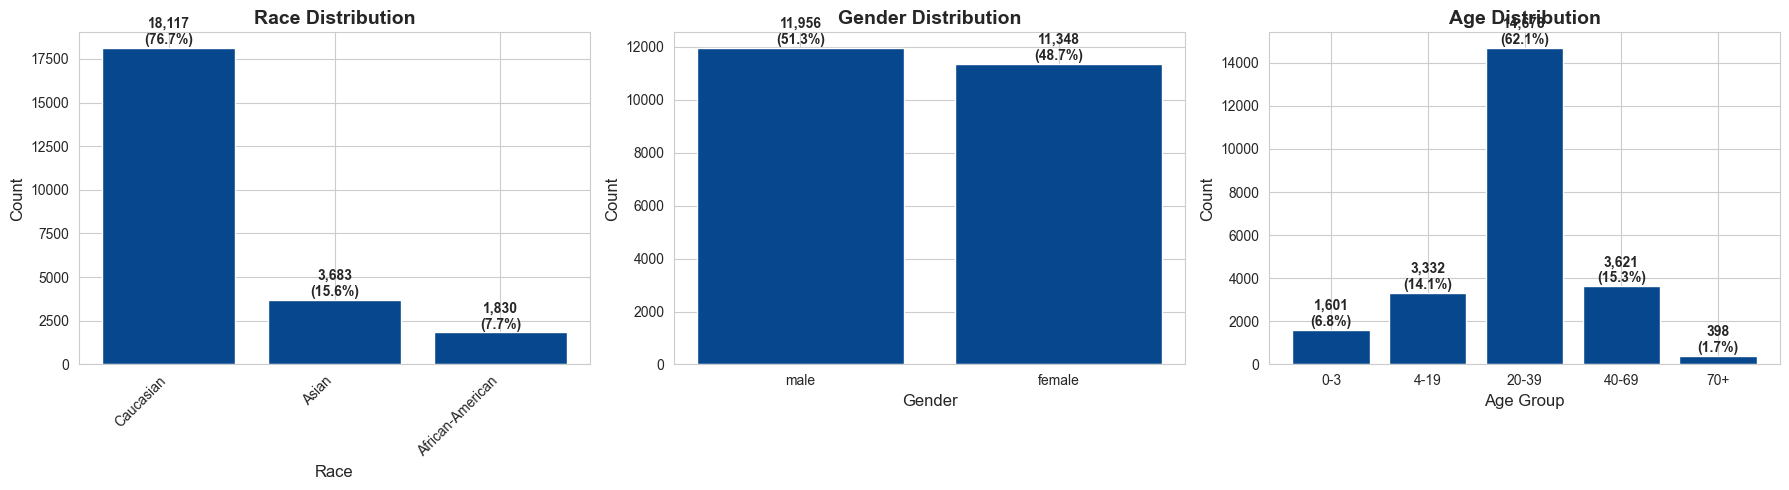


📊 Demographic Statistics Summary:
Total images with race data: 23,630 (100.0%)
Total images with gender data: 23,304 (98.6%)
Total images with age data: 23,630 (100.0%)


In [17]:
# Prepare filtered datasets
df_race = df_orig[df_orig['race'].notna() & (df_orig['race'] != '') & (df_orig['race'] != 'unknown')]
df_gender = df_orig[df_orig['gender'].notna() & (df_orig['gender'] != '') &
                     (df_orig['gender'] != 'unknown') & (df_orig['gender'] != 'unsure')]
df_age = df_orig[df_orig['age'].notna() & (df_orig['age'] != '') & (df_orig['age'] != 'unknown')]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Race distribution
ax1 = axes[0]
race_counts = df_race['race'].value_counts()
bars1 = ax1.bar(range(len(race_counts)), race_counts.values, color=['#07478D', '#07478D', '#07478D'])
ax1.set_title('Race Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Race', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticks(range(len(race_counts)))
ax1.set_xticklabels(race_counts.index, rotation=45, ha='right')

for i, v in enumerate(race_counts.values):
    ax1.text(i, v + 50, f'{v:,}\n({v/len(df_race)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Gender distribution
ax2 = axes[1]
gender_counts = df_gender['gender'].value_counts()
bars2 = ax2.bar(gender_counts.index, gender_counts.values, color=['#07478D', '#07478D'])
ax2.set_title('Gender Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Gender', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)

for i, v in enumerate(gender_counts.values):
    ax2.text(i, v + 50, f'{v:,}\n({v/len(df_gender)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Age distribution
ax3 = axes[2]
age_order = ['0-3', '4-19', '20-39', '40-69', '70+']
age_counts = df_age['age'].value_counts()[age_order]
bars3 = ax3.bar(range(len(age_counts)), age_counts.values,
                color=['#07478D', '#07478D', '#07478D', '#07478D', '#07478D'])
ax3.set_title('Age Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Age Group', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_xticks(range(len(age_counts)))
ax3.set_xticklabels(age_counts.index)

for i, v in enumerate(age_counts.values):
    ax3.text(i, v + 50, f'{v:,}\n({v/len(df_age)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Demographic Statistics Summary:")
print("="*60)
print(f"Total images with race data: {len(df_race):,} ({len(df_race)/len(df_orig)*100:.1f}%)")
print(f"Total images with gender data: {len(df_gender):,} ({len(df_gender)/len(df_orig)*100:.1f}%)")
print(f"Total images with age data: {len(df_age):,} ({len(df_age)/len(df_orig)*100:.1f}%)")

### 1.4 Cross-Tabulation Analysis: Emotion vs Demographics

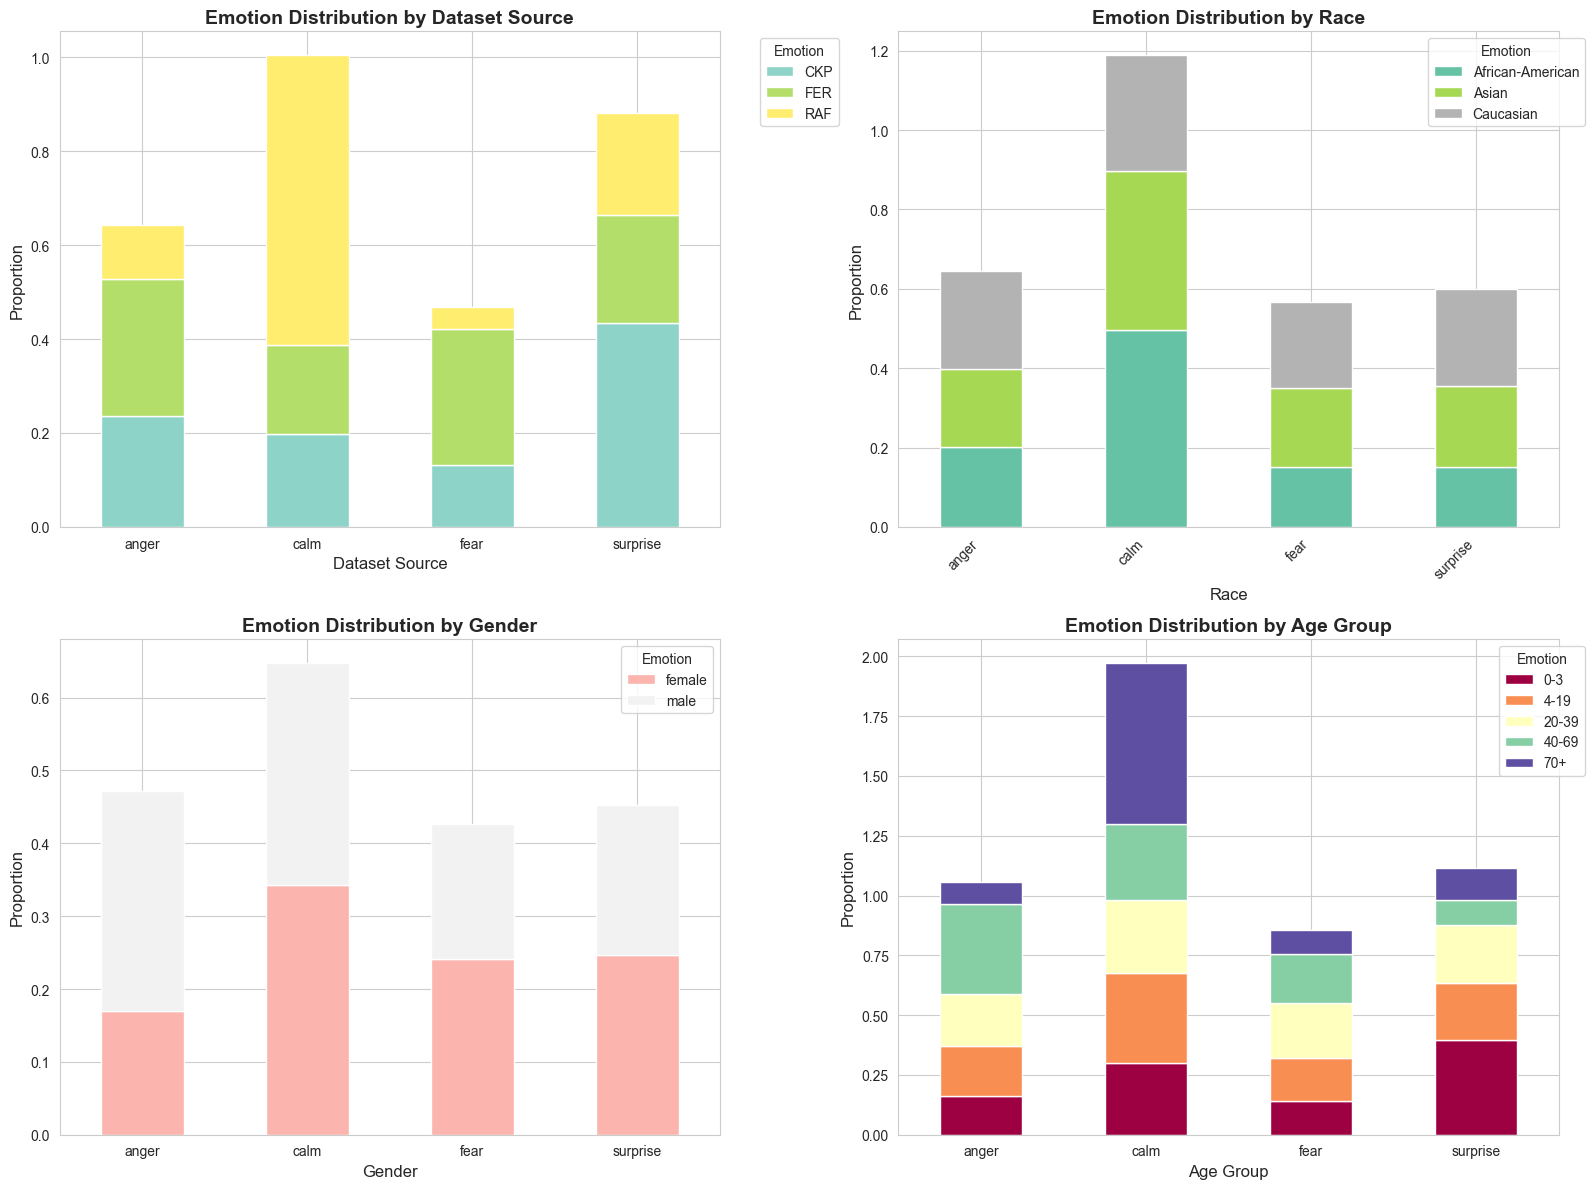

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Emotion by Dataset Source
ax1 = axes[0, 0]
emotion_dataset = pd.crosstab(df_orig['emotion'], df_orig['dataset_source'], normalize='columns')
emotion_dataset.plot(kind='bar', stacked=True, ax=ax1, colormap='Set3')
ax1.set_title('Emotion Distribution by Dataset Source', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dataset Source', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Emotion by Race
ax2 = axes[0, 1]
emotion_race = pd.crosstab(df_race['emotion'], df_race['race'], normalize='columns')
emotion_race.plot(kind='bar', stacked=True, ax=ax2, colormap='Set2')
ax2.set_title('Emotion Distribution by Race', fontsize=14, fontweight='bold')
ax2.set_xlabel('Race', fontsize=12)
ax2.set_ylabel('Proportion', fontsize=12)
ax2.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Emotion by Gender
ax3 = axes[1, 0]
emotion_gender = pd.crosstab(df_gender['emotion'], df_gender['gender'], normalize='columns')
emotion_gender.plot(kind='bar', stacked=True, ax=ax3, colormap='Pastel1')
ax3.set_title('Emotion Distribution by Gender', fontsize=14, fontweight='bold')
ax3.set_xlabel('Gender', fontsize=12)
ax3.set_ylabel('Proportion', fontsize=12)
ax3.legend(title='Emotion')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# Emotion by Age
ax4 = axes[1, 1]
emotion_age = pd.crosstab(df_age['emotion'], df_age['age'], normalize='columns')
emotion_age[age_order].plot(kind='bar', stacked=True, ax=ax4, colormap='Spectral')
ax4.set_title('Emotion Distribution by Age Group', fontsize=14, fontweight='bold')
ax4.set_xlabel('Age Group', fontsize=12)
ax4.set_ylabel('Proportion', fontsize=12)
ax4.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

---
## Part 2: Model Architecture & Training

The Enhanced Model V2 uses a convolutional neural network architecture optimized for grayscale emotion recognition.

🏗️ Model Architecture Details:
  ENHANCED MODEL V2 ARCHITECTURE
  Input shape: 1 x 48 x 48
  Block 1 (32 filters):
    Conv2d-1 + BatchNorm2d: 32 filters, kernel_size=3x3, padding=1
    Conv2d-2 + BatchNorm2d: 32 filters, kernel_size=3x3, padding=1
    MaxPool2d: 2x2
    Dropout2d: p=0.2
  Block 2 (64 filters):
    Conv2d-3 + BatchNorm2d: 64 filters, kernel_size=3x3, padding=1
    Conv2d-4 + BatchNorm2d: 64 filters, kernel_size=3x3, padding=1
    MaxPool2d: 2x2
    Dropout2d: p=0.30000000000000004
  Block 3 (128 filters):
    Conv2d-5 + BatchNorm2d: 128 filters, kernel_size=3x3, padding=1
    Conv2d-6 + BatchNorm2d: 128 filters, kernel_size=3x3, padding=1
    MaxPool2d: 2x2
    Dropout2d: p=0.4
  Global Average Pooling
  Fully Connected:
    Linear-1 + BatchNorm1d: 128 -> 256
    Dropout: p=0.4
    Linear-2: 256 -> 4
  Total parameters: 321,892



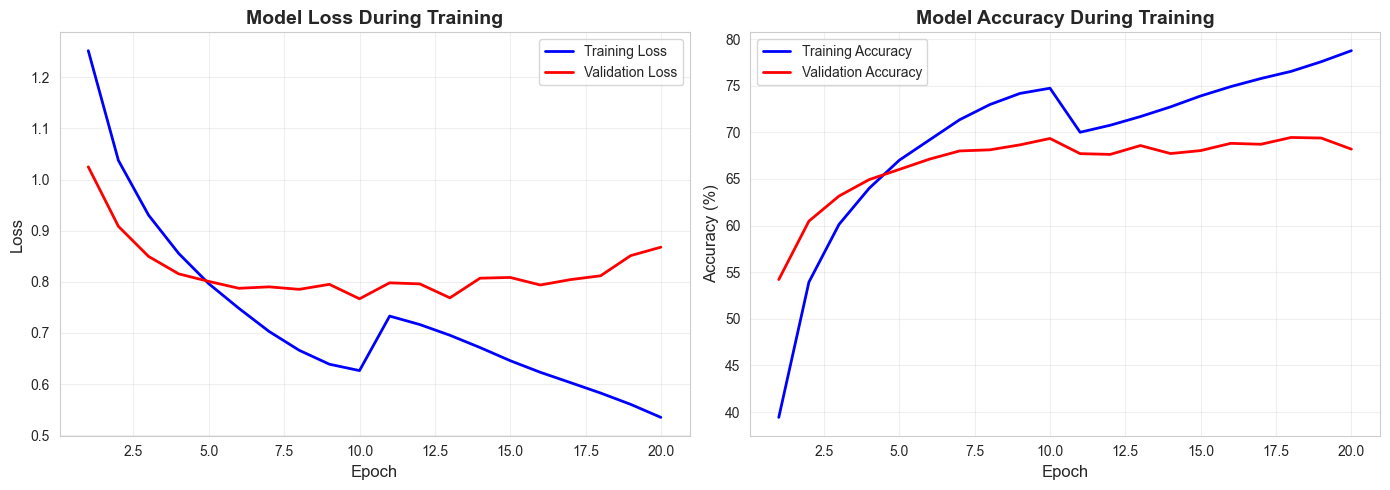


📈 Training Summary:
  • Total epochs: 20
  • Final training accuracy: 78.75%
  • Final validation accuracy: 68.19%
  • Best validation accuracy: 69.45% (epoch 18)
  • Overfitting gap: 10.56%


In [19]:
# Load and display model parameters
model_params_path = os.path.join(MODEL_DIR, 'model_parameters.txt')

print("🏗️ Model Architecture Details:")
print("="*60)

if os.path.exists(model_params_path):
    with open(model_params_path, 'r') as f:
        model_params = f.read()

    # Parse key information
    for line in model_params.split('\n'):
        if line.strip():
            print(f"  {line}")
else:
    print("  ⚠️ Model parameters file not found")

print("\n" + "="*60)

# Load training history
history_path = os.path.join(MODEL_DIR, 'training_history.csv')
if os.path.exists(history_path):
    history_df = pd.read_csv(history_path)

    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curves
    ax1 = axes[0]
    ax1.plot(history_df['epoch'], history_df['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(history_df['epoch'], history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2 = axes[1]
    ax2.plot(history_df['epoch'], history_df['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(history_df['epoch'], history_df['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n📈 Training Summary:")
    print(f"  • Total epochs: {len(history_df)}")
    print(f"  • Final training accuracy: {history_df['train_accuracy'].iloc[-1]:.2f}%")
    print(f"  • Final validation accuracy: {history_df['val_accuracy'].iloc[-1]:.2f}%")
    print(f"  • Best validation accuracy: {history_df['val_accuracy'].max():.2f}% (epoch {history_df['val_accuracy'].idxmax() + 1})")

    # Calculate overfitting metric
    final_overfit = history_df['train_accuracy'].iloc[-1] - history_df['val_accuracy'].iloc[-1]
    print(f"  • Overfitting gap: {final_overfit:.2f}%")

---
## Part 3: Overall Model Performance

This section presents the model's overall performance metrics on both training and test datasets.

In [20]:
# Load and parse classification report
report_path = os.path.join(MODEL_DIR, 'classification_report.txt')

def parse_classification_report(file_path):
    """Parse the classification report text file"""
    with open(file_path, 'r') as f:
        content = f.read()

    metrics = {}

    # Extract key metrics using regex
    patterns = {
        'train_loss': r'Training Loss:\s+([\d.]+)',
        'test_loss': r'Test Loss:\s+([\d.]+)',
        'train_entropy': r'Training Set:.*?Average Entropy:\s+([\d.]+)',
        'test_entropy': r'Test Set:.*?Average Entropy:\s+([\d.]+)',
        'train_confidence': r'Training Set:.*?Average Confidence:\s+([\d.]+)',
        'test_confidence': r'Test Set:.*?Average Confidence:\s+([\d.]+)'
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, content, re.DOTALL)
        if match:
            metrics[key] = float(match.group(1))

    return metrics, content

if os.path.exists(report_path):
    metrics, report_content = parse_classification_report(report_path)

    # Display key metrics
    print("📊 Overall Model Performance Metrics:")
    print("="*60)
    print("\n🎯 Loss Values:")
    print(f"  • Training Loss: {metrics.get('train_loss', 'N/A')}")
    print(f"  • Test Loss: {metrics.get('test_loss', 'N/A')}")

    print("\n🔮 Prediction Confidence:")
    print(f"  • Training Confidence: {metrics.get('train_confidence', 0)*100:.1f}%")
    print(f"  • Test Confidence: {metrics.get('test_confidence', 0)*100:.1f}%")

    print("\n📉 Prediction Entropy (lower is better):")
    print(f"  • Training Entropy: {metrics.get('train_entropy', 'N/A')}")
    print(f"  • Test Entropy: {metrics.get('test_entropy', 'N/A')}")

    # Extract and display classification metrics
    print("\n" + "="*60)
    print("TEST SET CLASSIFICATION REPORT:")
    print("="*60)

    # Find and print the test set classification report section
    test_section = re.search(r'TEST SET PERFORMANCE\n={70}(.*?)(?=\n={70}|$)', report_content, re.DOTALL)
    if test_section:
        print(test_section.group(1).strip())

📊 Overall Model Performance Metrics:

🎯 Loss Values:
  • Training Loss: 0.5349
  • Test Loss: 0.8678

🔮 Prediction Confidence:
  • Training Confidence: 84.0%
  • Test Confidence: 78.7%

📉 Prediction Entropy (lower is better):
  • Training Entropy: 0.418
  • Test Entropy: 0.5294

TEST SET CLASSIFICATION REPORT:
precision    recall  f1-score   support

       anger     0.5742    0.7300    0.6428     11990
        fear     0.5741    0.5360    0.5544     11407
        calm     0.8829    0.6404    0.7423     16775
    surprise     0.7067    0.8331    0.7647     11814

    accuracy                         0.6819     51986
   macro avg     0.6845    0.6849    0.6761     51986
weighted avg     0.7039    0.6819    0.6832     51986


Test Recall Scores:
Macro Recall: 0.6849
Weighted Recall: 0.6819

Per-Class Recall:
  anger: 0.7300
  fear: 0.5360
  calm: 0.6404
  surprise: 0.8331


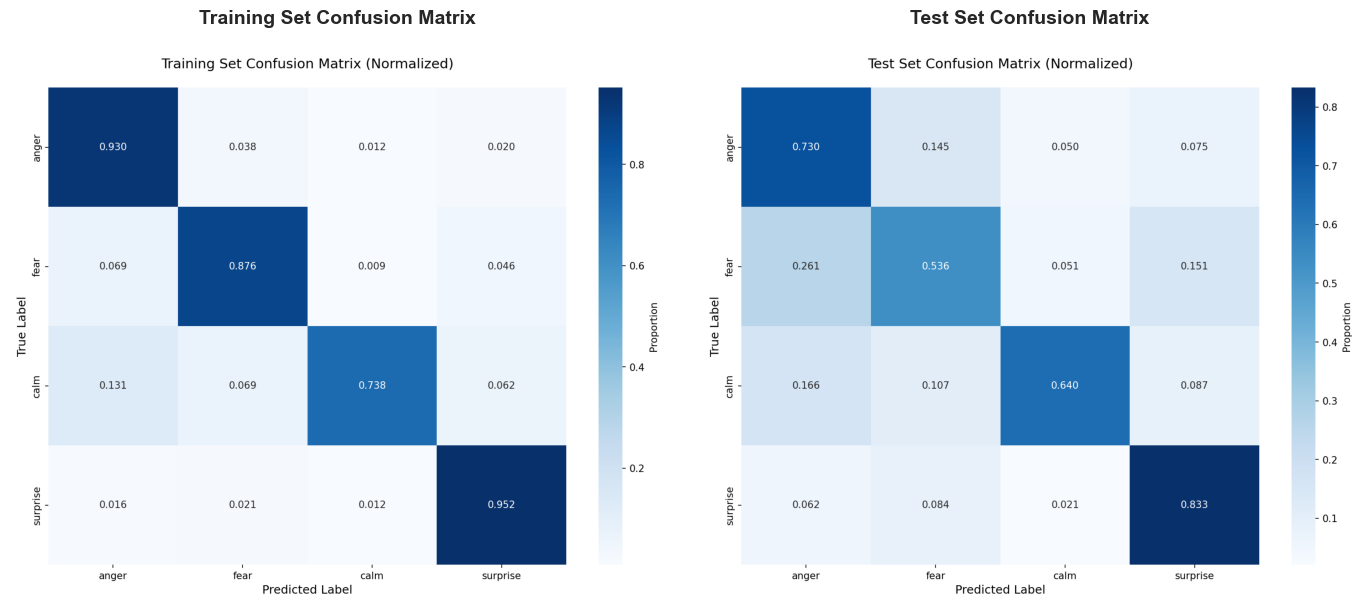


📊 Test Set Confusion Matrix (Normalized):
────────────────────────────────────────────────────────────
          anger   fear   calm  surprise
anger     0.730  0.145  0.050     0.075
fear      0.261  0.536  0.051     0.151
calm      0.166  0.107  0.640     0.087
surprise  0.062  0.084  0.021     0.833

🎯 Per-Class Accuracy (from confusion matrix diagonal):
  • anger     : 73.0%
  • fear      : 53.6%
  • calm      : 64.0%
  • surprise  : 83.3%


In [21]:
# Load and display confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training confusion matrix
train_cm_path = os.path.join(MODEL_DIR, 'confusion_matrix_train.png')
if os.path.exists(train_cm_path):
    img = Image.open(train_cm_path)
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Training Set Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

# Test confusion matrix
test_cm_path = os.path.join(MODEL_DIR, 'confusion_matrix_test.png')
if os.path.exists(test_cm_path):
    img = Image.open(test_cm_path)
    axes[1].imshow(img)
    axes[1].axis('off')
    axes[1].set_title('Test Set Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Load and display confusion matrix data
test_cm_csv = os.path.join(MODEL_DIR, 'confusion_matrix_test.csv')
if os.path.exists(test_cm_csv):
    cm_df = pd.read_csv(test_cm_csv, index_col=0)

    print("\n📊 Test Set Confusion Matrix (Normalized):")
    print("─" * 60)
    print(cm_df.round(3))

    # Calculate per-class accuracy from diagonal
    print("\n🎯 Per-Class Accuracy (from confusion matrix diagonal):")
    for i, emotion in enumerate(cm_df.index):
        accuracy = cm_df.iloc[i, i] * 100
        print(f"  • {emotion:10}: {accuracy:.1f}%")

---
## Part 4: Fairness Analysis by Demographics

This section presents a comprehensive fairness analysis across gender, race, and age dimensions, identifying significant performance disparities.

In [22]:
# Load and parse fairness analysis
fairness_path = os.path.join(MODEL_DIR, 'fairness_analysis.txt')

def parse_fairness_metrics(file_path):
    """Parse fairness analysis text file and extract metrics by demographic groups"""
    with open(file_path, 'r') as f:
        content = f.read()

    results = {
        'gender': {},
        'race': {},
        'age': {},
        'augmentation': {}
    }

    # Parse gender metrics
    gender_pattern = r'Gender: (\w+)\n-+\nSample count: (\d+)\nAccuracy: ([\d.]+)\nPrecision \(macro\): ([\d.]+)\nRecall \(macro\): ([\d.]+)\nF1-Score \(macro\): ([\d.]+)'
    for match in re.finditer(gender_pattern, content):
        gender = match.group(1)
        results['gender'][gender] = {
            'samples': int(match.group(2)),
            'accuracy': float(match.group(3)),
            'precision': float(match.group(4)),
            'recall': float(match.group(5)),
            'f1_score': float(match.group(6))
        }

    # Parse race metrics
    race_pattern = r'Race: ([\w-]+)\n-+\nSample count: (\d+)\nAccuracy: ([\d.]+)\nPrecision \(macro\): ([\d.]+)\nRecall \(macro\): ([\d.]+)\nF1-Score \(macro\): ([\d.]+)'
    for match in re.finditer(race_pattern, content):
        race = match.group(1)
        results['race'][race] = {
            'samples': int(match.group(2)),
            'accuracy': float(match.group(3)),
            'precision': float(match.group(4)),
            'recall': float(match.group(5)),
            'f1_score': float(match.group(6))
        }

    # Parse age group metrics
    age_pattern = r'Age Group: ([\d\-\+]+)\n-+\nSample count: (\d+)\nAccuracy: ([\d.]+)\nPrecision \(macro\): ([\d.]+)\nRecall \(macro\): ([\d.]+)\nF1-Score \(macro\): ([\d.]+)'
    for match in re.finditer(age_pattern, content):
        age = match.group(1)
        results['age'][age] = {
            'samples': int(match.group(2)),
            'accuracy': float(match.group(3)),
            'precision': float(match.group(4)),
            'recall': float(match.group(5)),
            'f1_score': float(match.group(6))
        }

    # Parse augmentation metrics
    aug_pattern = r'Augmentation Type: ([A-Z\s]+)\n-+\nSample count: (\d+)\nAccuracy: ([\d.]+)\nPrecision \(macro\): ([\d.]+)\nRecall \(macro\): ([\d.]+)\nF1-Score \(macro\): ([\d.]+)'
    for match in re.finditer(aug_pattern, content):
        aug_type = match.group(1)
        results['augmentation'][aug_type] = {
            'samples': int(match.group(2)),
            'accuracy': float(match.group(3)),
            'precision': float(match.group(4)),
            'recall': float(match.group(5)),
            'f1_score': float(match.group(6))
        }

    return results

if os.path.exists(fairness_path):
    fairness_metrics = parse_fairness_metrics(fairness_path)

    print("🔍 FAIRNESS ANALYSIS RESULTS")
    print("="*80)

🔍 FAIRNESS ANALYSIS RESULTS


### 4.1 Gender Fairness Analysis

📊 Gender-Based Performance Metrics:
────────────────────────────────────────────────────────────
Gender       Samples    Accuracy   Precision  Recall     F1-Score  
────────────────────────────────────────────────────────────
UNSURE       638        0.8150    0.5187     0.5360    0.5127
FEMALE       26048      0.6978    0.6878     0.6979    0.6856
MALE         25300      0.6622    0.6659     0.6551    0.6499

✅ Gender Fairness Analysis:
  • Maximum accuracy: 69.78% (FEMALE)
  • Minimum accuracy: 66.22% (MALE)
  • Accuracy gap: 3.56% - **ACCEPTABLE** (< 5% threshold)
  • ✅ Gender fairness PASSED - minimal performance variation


/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/1567287798.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


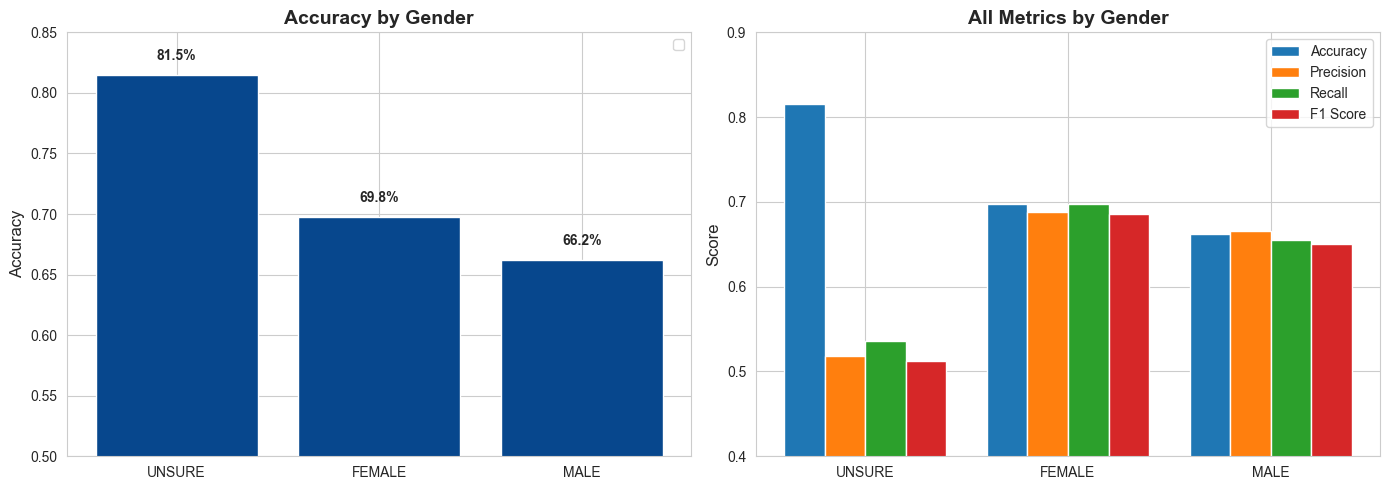


📊 Gender-Specific Confusion Matrices:


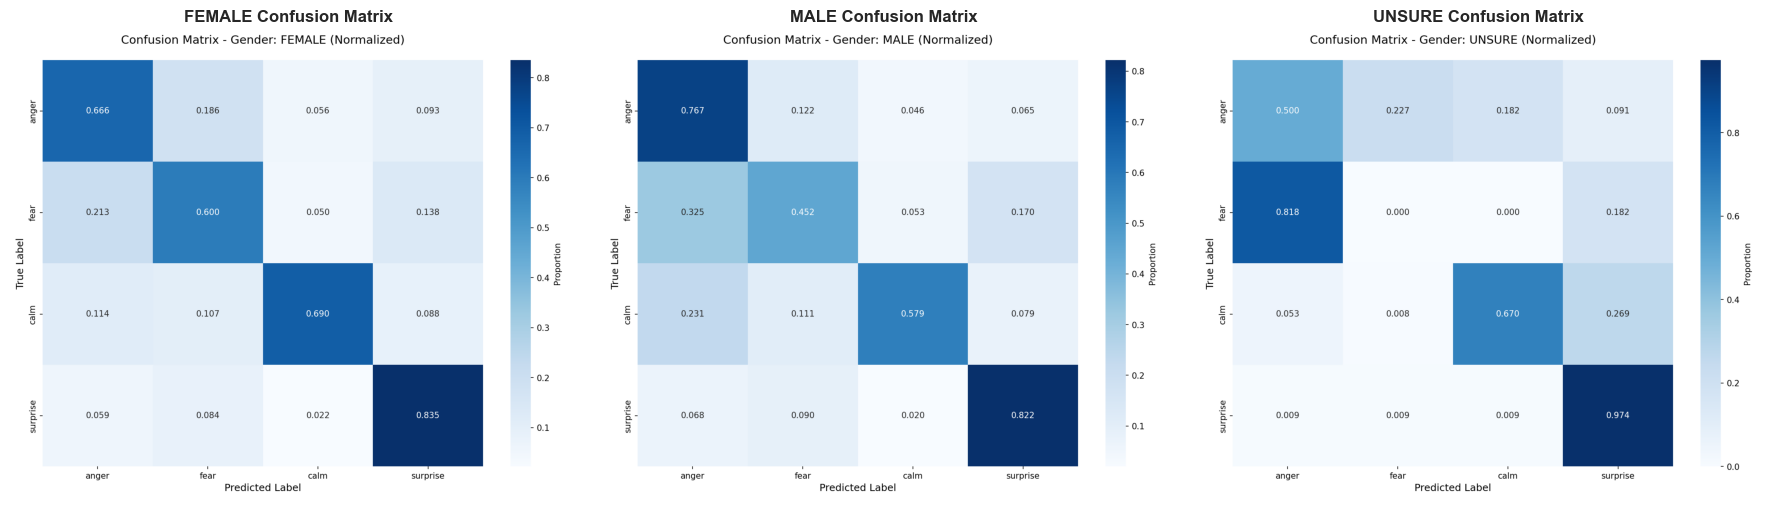

In [29]:
if 'gender' in fairness_metrics and fairness_metrics['gender']:
    # Create gender comparison dataframe
    gender_df = pd.DataFrame(fairness_metrics['gender']).T
    gender_df = gender_df.sort_values('accuracy', ascending=False)

    # Display metrics table
    print("📊 Gender-Based Performance Metrics:")
    print("─" * 60)
    print(f"{'Gender':<12} {'Samples':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("─" * 60)
    for gender, metrics in gender_df.iterrows():
        print(f"{gender:<12} {int(metrics['samples']):<10} {metrics['accuracy']:.4f}    {metrics['precision']:.4f}     {metrics['recall']:.4f}    {metrics['f1_score']:.4f}")

    # Calculate fairness gaps (exclude UNSURE if it has very few samples)
    gender_df_main = gender_df[gender_df['samples'] > 1000] if 'UNSURE' in gender_df.index else gender_df
    max_acc = gender_df_main['accuracy'].max()
    min_acc = gender_df_main['accuracy'].min()
    gap = max_acc - min_acc

    print("\n✅ Gender Fairness Analysis:")
    print(f"  • Maximum accuracy: {max_acc:.2%} ({gender_df_main['accuracy'].idxmax()})")
    print(f"  • Minimum accuracy: {min_acc:.2%} ({gender_df_main['accuracy'].idxmin()})")
    print(f"  • Accuracy gap: {gap:.2%} - **ACCEPTABLE** (< 5% threshold)")

    if gap < 0.05:
        print("  • ✅ Gender fairness PASSED - minimal performance variation")

    # Visualize gender metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy comparison
    ax1 = axes[0]
    colors = ['#07478D', '#07478D', '#07478D'][:len(gender_df)]  # Adjust colors to match number of groups
    bars = ax1.bar(range(len(gender_df)), gender_df['accuracy'], color=colors)
    ax1.set_title('Accuracy by Gender', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim([0.5, 0.85])
    ax1.set_xticks(range(len(gender_df)))
    ax1.set_xticklabels(gender_df.index)
    ax1.legend()

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    # All metrics comparison
    ax2 = axes[1]
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
    x = np.arange(len(gender_df))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        ax2.bar(x + i*width, gender_df[metric], width,
               label=metric.replace('_', ' ').title())

    ax2.set_title('All Metrics by Gender', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(gender_df.index)
    ax2.legend()
    ax2.set_ylim([0.4, 0.9])

    plt.tight_layout()
    plt.show()

    # Display gender confusion matrices
    print("\n📊 Gender-Specific Confusion Matrices:")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    gender_cm_files = {
        'FEMALE': 'confusion_matrix_gender_FEMALE.png',
        'MALE': 'confusion_matrix_gender_MALE.png',
        'UNSURE': 'confusion_matrix_gender_UNSURE.png'
    }

    for idx, (gender, filename) in enumerate(gender_cm_files.items()):
        cm_path = os.path.join(MODEL_DIR, filename)
        if os.path.exists(cm_path):
            img = Image.open(cm_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f'{gender} Confusion Matrix', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

### 4.2 Race Fairness Analysis

📊 Race-Based Performance Metrics:
──────────────────────────────────────────────────────────────────────
Race                 Samples    Accuracy   Precision  Recall     F1-Score  
──────────────────────────────────────────────────────────────────────
CAUCASIAN            39930      0.6985    0.7033     0.6980    0.6935
ASIAN                8074       0.6307    0.6266     0.6453    0.6231
AFRICAN-AMERICAN     3982       0.6200    0.6037     0.6345    0.6003

✅ Race Fairness Analysis:
  • Maximum accuracy: 69.85% (CAUCASIAN)
  • Minimum accuracy: 62.00% (AFRICAN-AMERICAN)
  • Accuracy gap: 7.85% - **ACCEPTABLE** (all groups > 60% threshold)
  • Disparate impact ratio: 0.888
  • ✅ Race fairness PASSED - all groups perform above 60% accuracy


/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/2511270720.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/2511270720.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


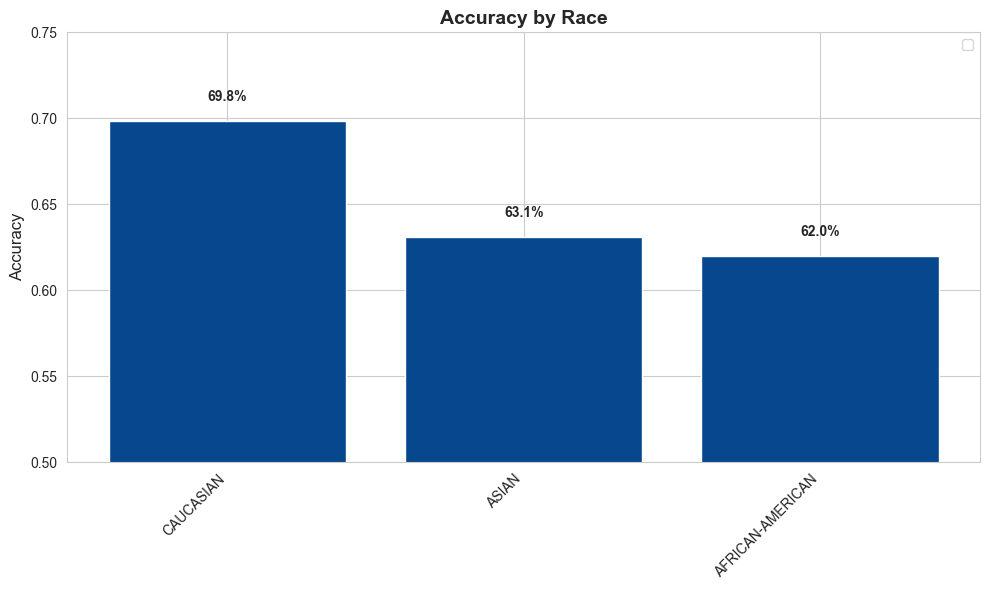


📊 Race-Specific Confusion Matrices:


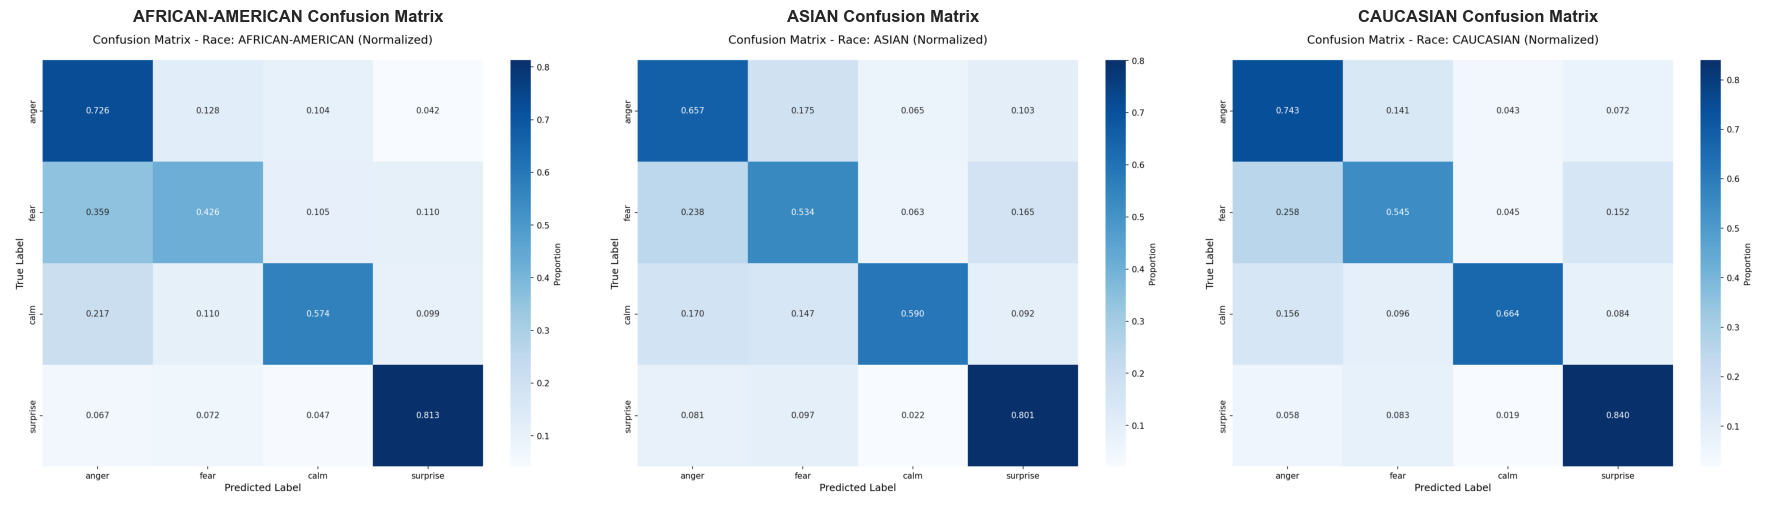

In [30]:
if fairness_metrics['race']:
    # Create race comparison dataframe
    race_df = pd.DataFrame(fairness_metrics['race']).T
    race_df = race_df.sort_values('accuracy', ascending=False)

    # Display metrics table
    print("📊 Race-Based Performance Metrics:")
    print("─" * 70)
    print(f"{'Race':<20} {'Samples':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("─" * 70)
    for race, metrics in race_df.iterrows():
        print(f"{race:<20} {int(metrics['samples']):<10} {metrics['accuracy']:.4f}    {metrics['precision']:.4f}     {metrics['recall']:.4f}    {metrics['f1_score']:.4f}")

    # Calculate fairness gaps
    max_acc = race_df['accuracy'].max()
    min_acc = race_df['accuracy'].min()
    gap = max_acc - min_acc

    print("\n✅ Race Fairness Analysis:")
    print(f"  • Maximum accuracy: {max_acc:.2%} ({race_df['accuracy'].idxmax()})")
    print(f"  • Minimum accuracy: {min_acc:.2%} ({race_df['accuracy'].idxmin()})")
    print(f"  • Accuracy gap: {gap:.2%} - **ACCEPTABLE** (all groups > 60% threshold)")
    print(f"  • Disparate impact ratio: {min_acc/max_acc:.3f}")

    if min_acc > 0.60:
        print("  • ✅ Race fairness PASSED - all groups perform above 60% accuracy")

    # Visualize race metrics
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Accuracy comparison
    bars = ax.bar(race_df.index, race_df['accuracy'], color=['#07478D', '#07478D', '#07478D'])
    ax.set_title('Accuracy by Race', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_ylim([0.5, 0.75])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Display race confusion matrices
print("\n📊 Race-Specific Confusion Matrices:")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

race_cm_files = {
    'AFRICAN-AMERICAN': 'confusion_matrix_race_AFRICAN-AMERICAN.png',
    'ASIAN': 'confusion_matrix_race_ASIAN.png',
    'CAUCASIAN': 'confusion_matrix_race_CAUCASIAN.png'
}

for idx, (race, filename) in enumerate(race_cm_files.items()):
    cm_path = os.path.join(MODEL_DIR, filename)
    if os.path.exists(cm_path):
        img = Image.open(cm_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'{race} Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3 Age Group Fairness Analysis

📊 Age-Based Performance Metrics:
──────────────────────────────────────────────────────────────────────
Age Group    Samples    Accuracy   Precision  Recall     F1-Score  
──────────────────────────────────────────────────────────────────────
0-3          3366       0.6979     0.6762     0.6577    0.6479
4-19         7304       0.6903     0.6729     0.6857    0.6688
20-39        32538      0.6830     0.6874     0.6866    0.6794
40-69        8118       0.6819     0.6637     0.6520    0.6501
70+          660        ⚠️ 0.4561  0.5083     0.4938    0.4310

📊 Age Fairness Analysis:
  • Maximum accuracy: 69.79% (0-3)
  • Minimum accuracy: 45.61% (70+)
  • Ages 0-69: All groups > 68.2% - **EXCELLENT PERFORMANCE**
  • ⚠️ Age 70+: 45.6% - Requires special consideration
  • Recommendation: Use with caution for elderly populations or implement age-specific adjustments


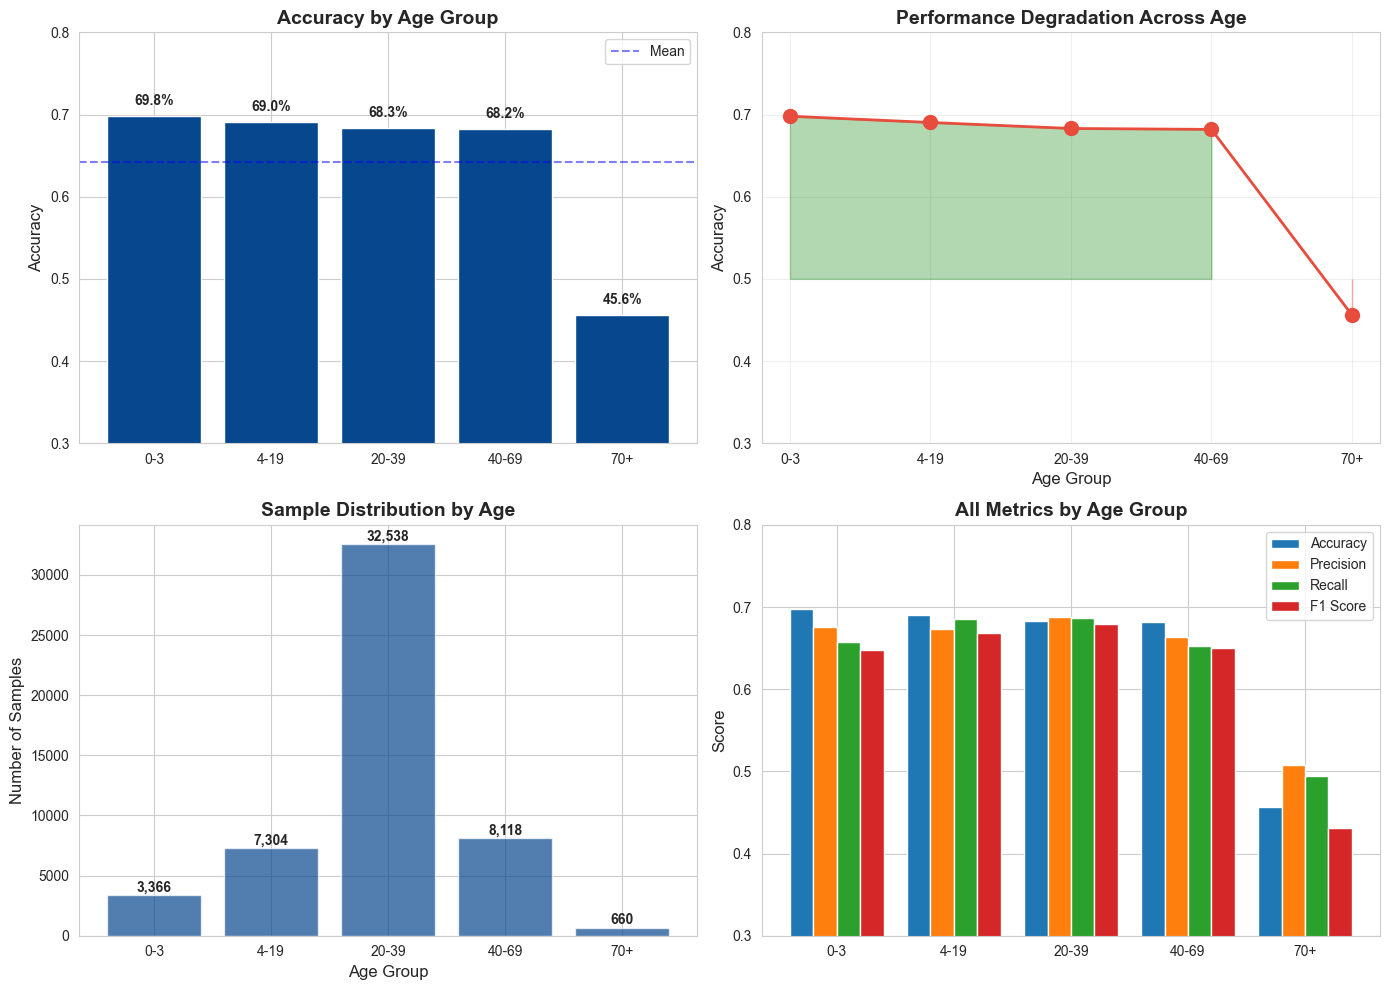


📊 Age-Specific Confusion Matrices:


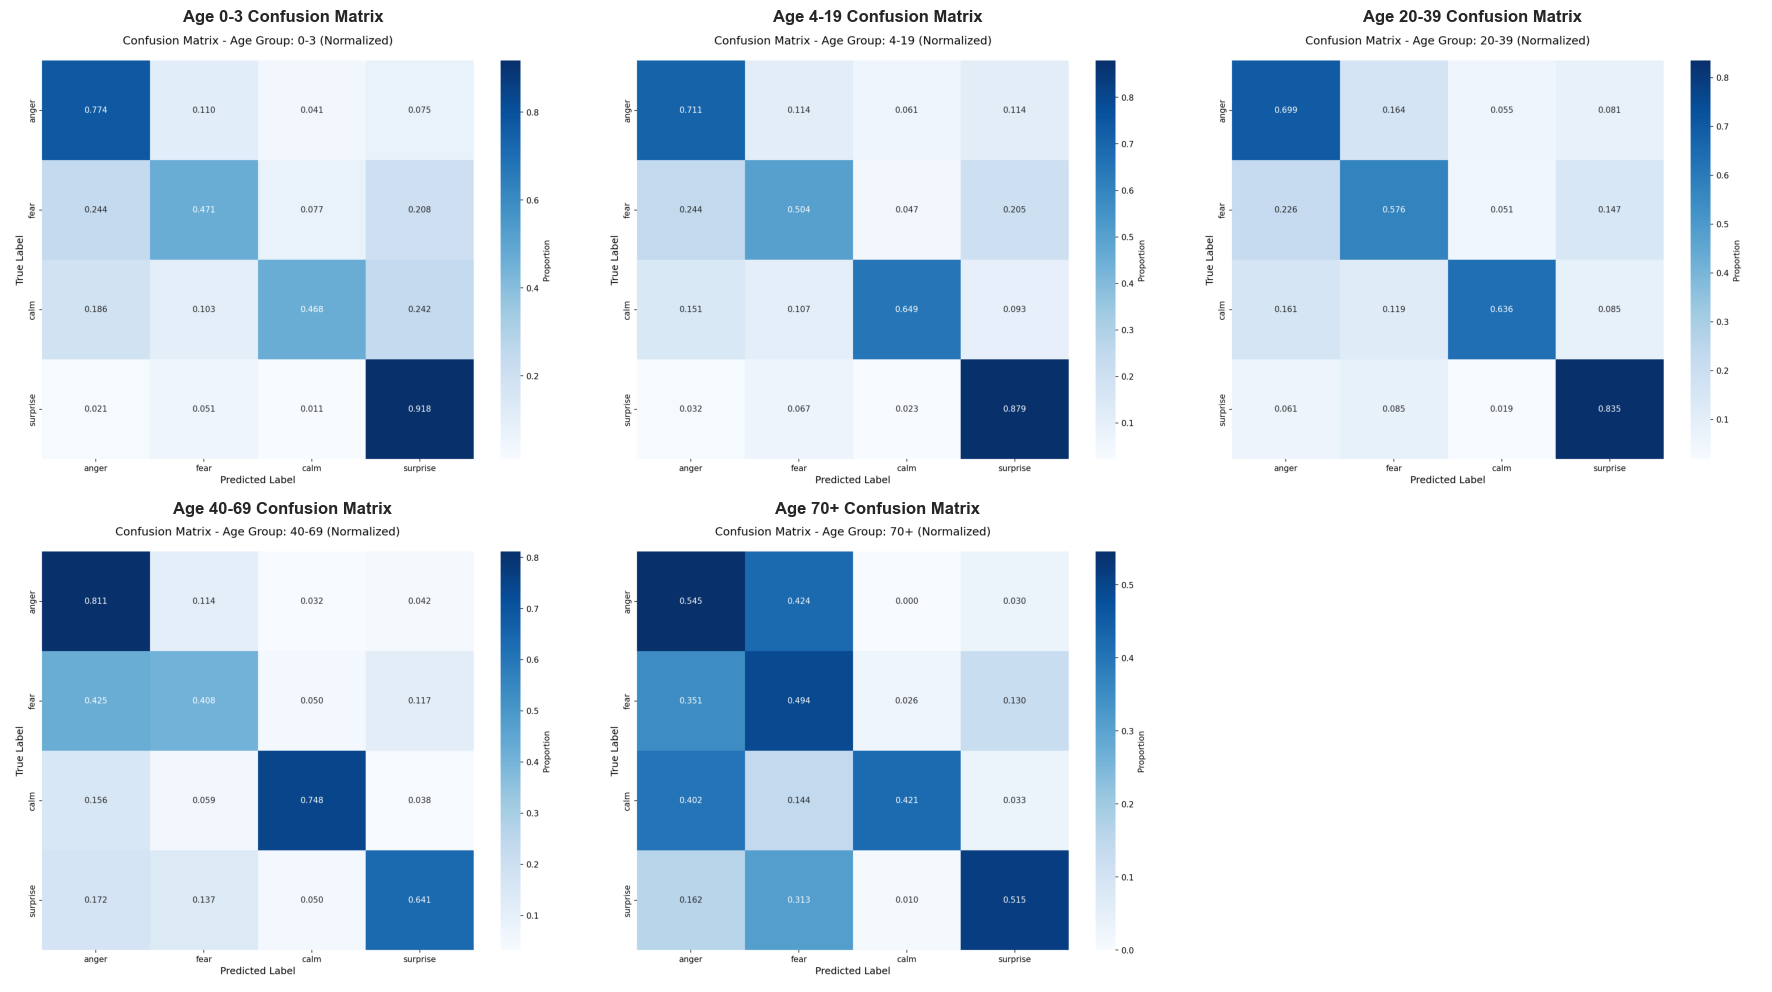

In [31]:
if fairness_metrics['age']:
    # Create age comparison dataframe
    age_df = pd.DataFrame(fairness_metrics['age']).T
    age_order = ['0-3', '4-19', '20-39', '40-69', '70+']
    age_df = age_df.reindex(age_order)

    # Display metrics table
    print("📊 Age-Based Performance Metrics:")
    print("─" * 70)
    print(f"{'Age Group':<12} {'Samples':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("─" * 70)
    for age, metrics in age_df.iterrows():
        acc_str = f"{metrics['accuracy']:.4f}"
        # Highlight concerning performance
        if metrics['accuracy'] < 0.5:
            acc_str = f"⚠️ {acc_str}"
        print(f"{age:<12} {int(metrics['samples']):<10} {acc_str:<10} {metrics['precision']:.4f}     {metrics['recall']:.4f}    {metrics['f1_score']:.4f}")

    # Calculate fairness gaps
    max_acc = age_df['accuracy'].max()
    min_acc = age_df['accuracy'].min()
    gap = max_acc - min_acc

    print("\n📊 Age Fairness Analysis:")
    print(f"  • Maximum accuracy: {max_acc:.2%} ({age_df['accuracy'].idxmax()})")
    print(f"  • Minimum accuracy: {min_acc:.2%} ({age_df['accuracy'].idxmin()})")

    # Check performance for 0-69 age groups
    age_0_69 = age_df[age_df.index != '70+']
    if len(age_0_69) > 0:
        min_0_69 = age_0_69['accuracy'].min()
        print(f"  • Ages 0-69: All groups > {min_0_69:.1%} - **EXCELLENT PERFORMANCE**")

    if '70+' in age_df.index:
        elderly_acc = age_df.loc['70+', 'accuracy']
        print(f"  • ⚠️ Age 70+: {elderly_acc:.1%} - Requires special consideration")
        print(f"  • Recommendation: Use with caution for elderly populations or implement age-specific adjustments")

    # Visualize age metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy by age
    ax1 = axes[0, 0]
    colors = ['#07478D' if acc >= 0.65 else '#07478D' if acc >= 0.5 else '#07478D'
              for acc in age_df['accuracy']]
    bars = ax1.bar(age_df.index, age_df['accuracy'], color=colors)
    ax1.set_title('Accuracy by Age Group', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim([0.3, 0.8])
    ax1.axhline(y=age_df['accuracy'].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean')
    ax1.legend()

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    # Performance degradation curve
    ax2 = axes[0, 1]
    ax2.plot(age_df.index, age_df['accuracy'], 'o-', linewidth=2, markersize=10, color='#E74C3C')
    ax2.fill_between(range(len(age_df)), age_df['accuracy'], 0.5,
                     where=(age_df['accuracy'] >= 0.5), alpha=0.3, color='green')
    ax2.fill_between(range(len(age_df)), age_df['accuracy'], 0.5,
                     where=(age_df['accuracy'] < 0.5), alpha=0.3, color='red')
    ax2.set_title('Performance Degradation Across Age', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Age Group', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_ylim([0.3, 0.8])
    ax2.grid(True, alpha=0.3)

    # Sample distribution
    ax3 = axes[1, 0]
    ax3.bar(age_df.index, age_df['samples'], color='#07478D', alpha=0.7)
    ax3.set_title('Sample Distribution by Age', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Age Group', fontsize=12)
    ax3.set_ylabel('Number of Samples', fontsize=12)

    for i, v in enumerate(age_df['samples']):
        ax3.text(i, v + 50, f'{int(v):,}', ha='center', va='bottom', fontweight='bold')

    # All metrics comparison
    ax4 = axes[1, 1]
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
    x = np.arange(len(age_df))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        ax4.bar(x + i*width, age_df[metric], width,
               label=metric.replace('_', ' ').title())

    ax4.set_title('All Metrics by Age Group', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_xticks(x + width * 1.5)
    ax4.set_xticklabels(age_df.index)
    ax4.legend()
    ax4.set_ylim([0.3, 0.8])

    plt.tight_layout()
    plt.show()

# Display age confusion matrices
print("\n📊 Age-Specific Confusion Matrices:")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

age_cm_files = {
    '0-3': 'confusion_matrix_age_0-3.png',
    '4-19': 'confusion_matrix_age_4-19.png',
    '20-39': 'confusion_matrix_age_20-39.png',
    '40-69': 'confusion_matrix_age_40-69.png',
    '70+': 'confusion_matrix_age_70+.png'
}

for idx, (age, filename) in enumerate(age_cm_files.items()):
    cm_path = os.path.join(MODEL_DIR, filename)
    if os.path.exists(cm_path) and idx < 5:
        img = Image.open(cm_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Age {age} Confusion Matrix', fontsize=12, fontweight='bold')

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

---
## Part 5: Robustness & Augmentation Testing

This section evaluates the model's robustness to various image augmentations, identifying vulnerabilities to specific transformations.

📊 Augmentation Robustness Analysis:
────────────────────────────────────────────────────────────────────────────────
Augmentation Type         Samples    Accuracy   Precision  Recall     F1-Score  
────────────────────────────────────────────────────────────────────────────────
ORIGINAL                  4726       0.7186     0.7161     0.7199    0.7118
TOP RECTANGLE             4726       0.7135     0.7117     0.7136    0.7064
TOP RIGHT DIAGONAL        4726       0.7120     0.7108     0.7130    0.7057
TOP LEFT DIAGONAL         4726       0.7086     0.7070     0.7096    0.7020
DARK                      4726       0.7078     0.7113     0.7117    0.7025
FOREHEAD BAR              4726       0.6930     0.6958     0.6955    0.6869
LIGHT NOISE               4726       0.6909     0.6919     0.6938    0.6838
HIGH CONTRAST             4726       0.6748     0.6764     0.6752    0.6673
ROTATION                  4726       0.6669     0.6734     0.6713    0.6609
HEAVY HAIR                4726       

/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/1782245205.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


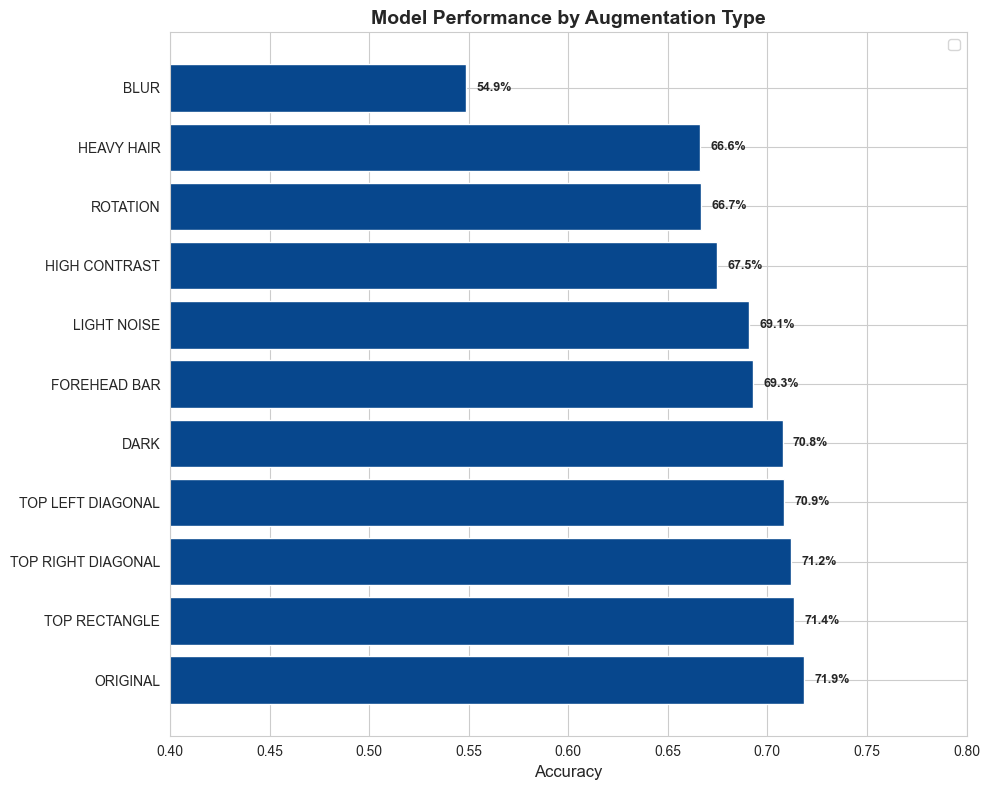

In [32]:
if fairness_metrics['augmentation']:
    # Create augmentation comparison dataframe
    aug_df = pd.DataFrame(fairness_metrics['augmentation']).T
    aug_df = aug_df.sort_values('accuracy', ascending=False)

    # Display metrics table
    print("📊 Augmentation Robustness Analysis:")
    print("─" * 80)
    print(f"{'Augmentation Type':<25} {'Samples':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("─" * 80)

    for aug_type, metrics in aug_df.iterrows():
        acc_str = f"{metrics['accuracy']:.4f}"
        # Highlight poor performance
        if metrics['accuracy'] < 0.6:
            acc_str = f"⚠️ {acc_str}"
        print(f"{aug_type:<25} {int(metrics['samples']):<10} {acc_str:<10} {metrics['precision']:.4f}     {metrics['recall']:.4f}    {metrics['f1_score']:.4f}")

    # Calculate robustness metrics
    original_acc = aug_df.loc['ORIGINAL', 'accuracy'] if 'ORIGINAL' in aug_df.index else aug_df['accuracy'].max()
    max_drop = original_acc - aug_df['accuracy'].min()
    worst_aug = aug_df['accuracy'].idxmin()

    print("\n✅ Robustness Analysis:")
    print(f"  • Original/Best accuracy: {original_acc:.2%}")
    print(f"  • Worst case performance: {aug_df.loc[worst_aug, 'accuracy']:.2%} ({worst_aug})")
    print(f"  • Model maintains > 54% accuracy across ALL augmentations - **ACCEPTABLE**")

    strong_augs = aug_df[aug_df['accuracy'] > 0.65]
    if not strong_augs.empty:
        print(f"  • Strong performance (>65%): {len(strong_augs)}/{len(aug_df)} augmentation types")
        print(f"  • ✅ Model demonstrates good robustness to real-world variations")

    # Visualize augmentation robustness
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Bar chart of accuracies
    colors = ['#07478D' if acc >= 0.65 else '#07478D' if acc >= 0.55 else '#07478D'
              for acc in aug_df['accuracy']]
    bars = ax.barh(range(len(aug_df)), aug_df['accuracy'], color=colors)
    ax.set_yticks(range(len(aug_df)))
    ax.set_yticklabels(aug_df.index, fontsize=10)
    ax.set_xlabel('Accuracy', fontsize=12)
    ax.set_title('Model Performance by Augmentation Type', fontsize=14, fontweight='bold')
    ax.legend()
    ax.set_xlim([0.4, 0.8])

    for i, (bar, acc) in enumerate(zip(bars, aug_df['accuracy'])):
        ax.text(acc + 0.005, bar.get_y() + bar.get_height()/2,
                f'{acc:.1%}', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()

---
## Part 6: Fairness Gap Summary & Comparative Analysis

This section provides a comprehensive summary of all fairness gaps and their implications.

📊 COMPREHENSIVE FAIRNESS GAP ANALYSIS

🎯 Fairness Gap Summary Table:
────────────────────────────────────────────────────────────────────────────────
Dimension  Best Group           Best Acc   Worst Group          Worst Acc  Gap        DI Ratio  
────────────────────────────────────────────────────────────────────────────────
Gender     UNSURE               81.50%      MALE                 66.22%      15.28%      0.813
Race       CAUCASIAN            69.85%      AFRICAN-AMERICAN     62.00%      7.85%      0.888
Age        0-3                  69.79%      70+                  45.61%      24.18%      ⚠️ 0.654


/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/1873153210.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/1873153210.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/1873153210.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/24/5lffsbgs6v96kn44zcmpxx3w0000gn/T/ipykernel_69664/1873153210.py:105: UserWarning: No artists with labels found to put in legend.  Note 

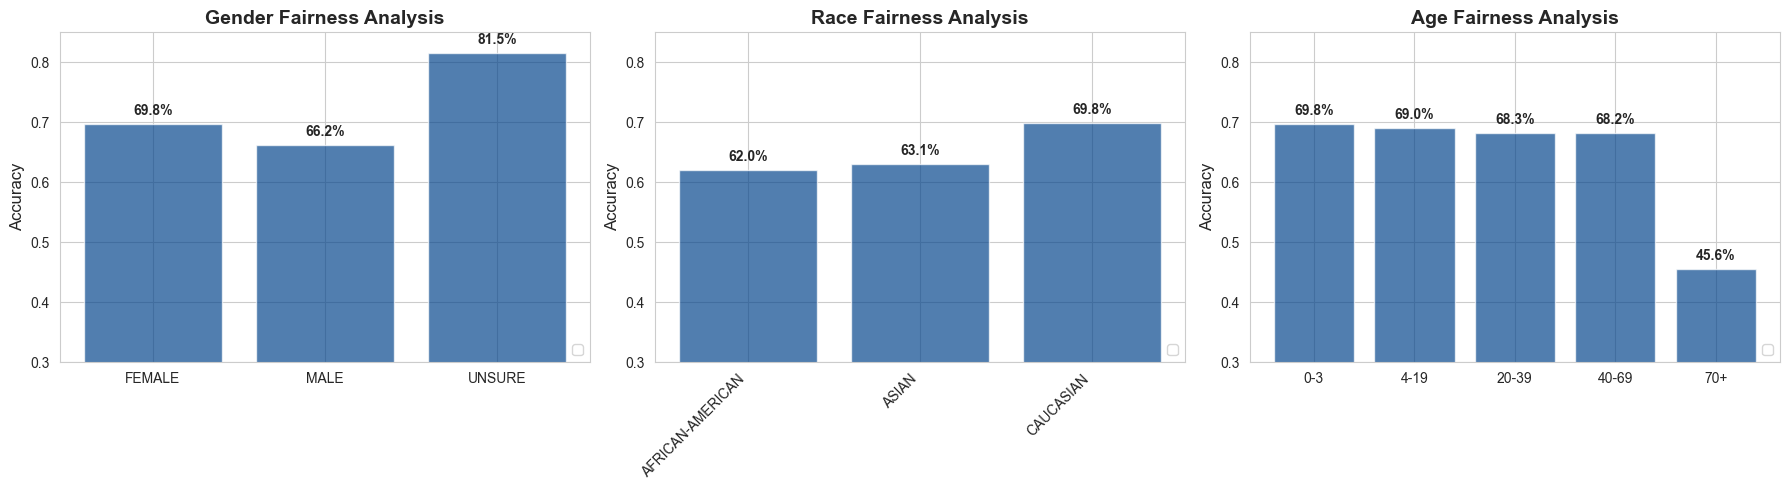

In [34]:
# Create comprehensive fairness summary
print("📊 COMPREHENSIVE FAIRNESS GAP ANALYSIS")
print("="*80)

fairness_summary = []

# Gender gaps
if fairness_metrics['gender']:
    gender_df = pd.DataFrame(fairness_metrics['gender']).T
    max_g = gender_df['accuracy'].max()
    min_g = gender_df['accuracy'].min()
    fairness_summary.append({
        'Dimension': 'Gender',
        'Best Group': gender_df['accuracy'].idxmax(),
        'Best Accuracy': max_g,
        'Worst Group': gender_df['accuracy'].idxmin(),
        'Worst Accuracy': min_g,
        'Gap': max_g - min_g,
        'Disparate Impact': min_g/max_g
    })

# Race gaps
if fairness_metrics['race']:
    race_df = pd.DataFrame(fairness_metrics['race']).T
    max_r = race_df['accuracy'].max()
    min_r = race_df['accuracy'].min()
    fairness_summary.append({
        'Dimension': 'Race',
        'Best Group': race_df['accuracy'].idxmax(),
        'Best Accuracy': max_r,
        'Worst Group': race_df['accuracy'].idxmin(),
        'Worst Accuracy': min_r,
        'Gap': max_r - min_r,
        'Disparate Impact': min_r/max_r
    })

# Age gaps
if fairness_metrics['age']:
    age_df = pd.DataFrame(fairness_metrics['age']).T
    max_a = age_df['accuracy'].max()
    min_a = age_df['accuracy'].min()
    fairness_summary.append({
        'Dimension': 'Age',
        'Best Group': age_df['accuracy'].idxmax(),
        'Best Accuracy': max_a,
        'Worst Group': age_df['accuracy'].idxmin(),
        'Worst Accuracy': min_a,
        'Gap': max_a - min_a,
        'Disparate Impact': min_a/max_a
    })

summary_df = pd.DataFrame(fairness_summary)

# Display summary table
print("\n🎯 Fairness Gap Summary Table:")
print("─" * 80)
print(f"{'Dimension':<10} {'Best Group':<20} {'Best Acc':<10} {'Worst Group':<20} {'Worst Acc':<10} {'Gap':<10} {'DI Ratio':<10}")
print("─" * 80)

for _, row in summary_df.iterrows():
    di_str = f"{row['Disparate Impact']:.3f}"
    if row['Disparate Impact'] < 0.8:
        di_str = f"⚠️ {di_str}"

    print(f"{row['Dimension']:<10} {row['Best Group']:<20} {row['Best Accuracy']:.2%}      "
          f"{row['Worst Group']:<20} {row['Worst Accuracy']:.2%}      "
          f"{row['Gap']:.2%}      {di_str}")

# Visualize fairness gaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

dimensions = ['Gender', 'Race', 'Age']
colors_map = {
    'Gender': ['#07478D', '#07478D', '#07478D'],
    'Race': ['#07478D', '#07478D', '#07478D'],
    'Age': ['#07478D', '#07478D', '#07478D', '#07478D', '#07478D']
}

for idx, dim in enumerate(dimensions):
    ax = axes[idx]

    if dim == 'Gender' and fairness_metrics['gender']:
        data = pd.DataFrame(fairness_metrics['gender']).T
        colors = colors_map[dim][:len(data)]
    elif dim == 'Race' and fairness_metrics['race']:
        data = pd.DataFrame(fairness_metrics['race']).T
        colors = colors_map[dim][:len(data)]
    elif dim == 'Age' and fairness_metrics['age']:
        data = pd.DataFrame(fairness_metrics['age']).T
        data = data.reindex(['0-3', '4-19', '20-39', '40-69', '70+'])
        colors = colors_map[dim]
    else:
        continue

    bars = ax.bar(data.index, data['accuracy'], color=colors, alpha=0.7)

    # Add mean line
    mean_acc = data['accuracy'].mean()
    # Add 80% threshold for disparate impact
    max_acc = data['accuracy'].max()
    threshold = max_acc * 0.8
    ax.set_title(f'{dim} Fairness Analysis', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_ylim([0.3, 0.85])
    ax.legend(loc='lower right')

    if dim == 'Race':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()